# Demonstration of `HitRateModel` Usage

This notebook demonstrates how to use the `HitRateModel` class for analyzing and simulating hit rates in virtual screening workflows.

Specifically, we illustrate the two main functions of the model:

- **`get_pprop_hr(pprop, definition)`**:  
  Visualize experimental vs. simulated **hit rate curves** as a function of `pProp` and hit threshold (`pKi definition`).

- **`sample(pprop)`**:  
  Generates **simulated experimental pKi values** based on the model. This function can be used to simulate virtual screening campaigns.

## Prepare Inputs for Examples
### Load Libraries

In [1]:
# --- Import necessary libraries ---
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from model import HitRateModel

### Load Experimental Data

In [2]:
# Load experimental hit rate data with confidence intervals
df = pd.read_csv("data/hitrates_conf_intervals.csv")

# Group the data by target for easy access
data = {target: subset for target, subset in df.groupby("target")}
n_targets = len(data)

# Quick look at the data
print(f"Number of targets: {n_targets}\n")
print(f"Sample from the dataframe that was used for fitting:")
print(df.sample(10).sort_values("target", ignore_index=True))

Number of targets: 3

Sample from the dataframe that was used for fitting:
   target  pprop  hit_rate_mean  hit_rate_low  hit_rate_high  definition
0    ampc    7.5       0.110827      0.000000       0.285714    4.397940
1    ampc    2.5       0.028763      0.000000       0.097561    3.397940
2    ampc    4.5       0.029611      0.006098       0.058140    4.397940
3    ampc    7.0       0.212175      0.098039       0.340000    4.397940
4      d4    6.0       0.165135      0.000000       0.360000    5.000000
5      d4    1.5       0.000000      0.000000       0.050629    6.000000
6      d4    6.5       0.132491      0.000000       0.333333    5.000000
7      d4    5.5       0.156589      0.037004       0.290323    6.000000
8      d4    1.5       0.042287      0.000000       0.095238    5.000000
9  sigma2    4.5       0.184950      0.102564       0.273814    7.188425


### Load Fitted Model Parameters

In [3]:
# Load the optimized model parameters for each target
with open("output/fitted_params.json", "r") as f:
    params = json.load(f)

# Check parameters for one of the targets
print(f"Example parameters for a target ({list(params.keys())[0]}):\n{params[list(params.keys())[0]]}")

Example parameters for a target (ampc):
{'artifact_mean': -5.0, 'artifact_std': 1.0, 'artifact_freq': 1e-07, 'rho': -0.6183379819169998, 'exp_mean': -0.49720514834249374, 'exp_std': 1.2502804039428599, 'MSE': 0.0022300738413743412, 'target': 'ampc'}


## Example 1: Visualizing Predicted vs Experimental Hit Rates (`get_pprop_hr`)
This section compares model-predicted hit rates with the experimental data at different pProps and hit thresholds (definition).

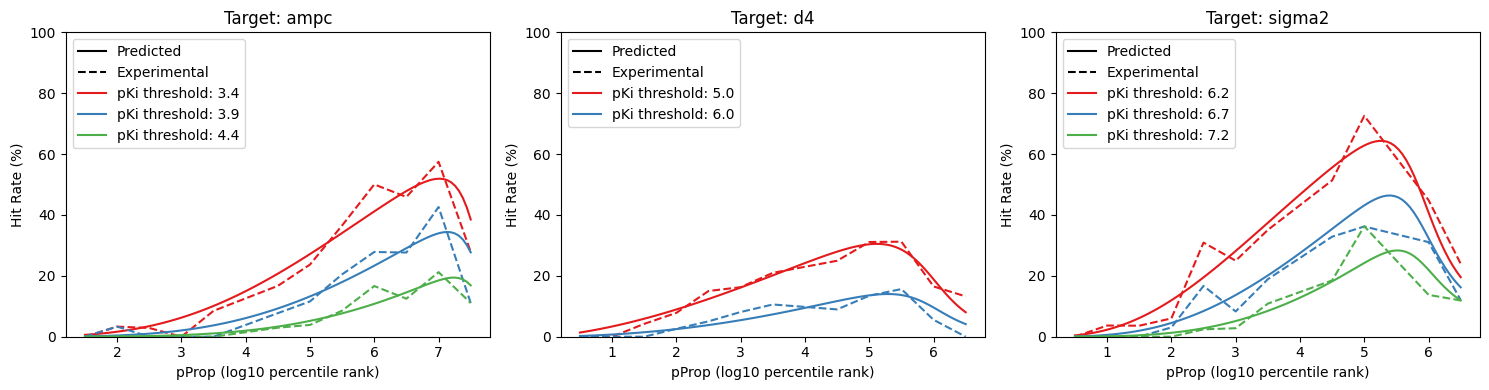

In [4]:
# Create a subplot for each target to compare predictions vs. experimental values
fig, axes = plt.subplots(1, n_targets, figsize=[n_targets*5, 4])

# Line styles for plot legend
ls_dict = {"Predicted": "-", "Experimental": "--"}

for i, target in enumerate(data):
    ax = axes[i]
    subset = data[target]
    hrm = HitRateModel(params[target])  # Initialize the model for this target

    # Set up legend elements
    legend_elements = [Line2D([0], [0], color='k', linestyle=ls_dict[label], label=label) for label in ls_dict]
    
    # Loop over each hit threshold (definition)
    for n, (definition, subsubset) in enumerate(subset.groupby("definition")):
        # Predict hit rates for a smooth pProp range
        pprop = np.linspace(subset.pprop.min(), subset.pprop.max(), 100)
        pred = hrm.get_pprop_hr(pprop, np.ones_like(pprop)*definition) * 100
        
        # Plot experimental and predicted hit rate curves in a definition specific color
        color = plt.get_cmap('Set1')(n)
        ax.plot(subsubset.pprop, subsubset.hit_rate_mean*100, ls="--", c=color)
        ax.plot(pprop, pred, c=color)
        legend_elements.append(Line2D([0],[0], color=color, label=f"pKi threshold: {definition:.1f}"))

    # Configure axis and legend
    ax.set_ylim(0, 100)
    ax.set_ylabel("Hit Rate (%)")
    ax.set_xlabel("pProp (log10 percentile rank)")
    ax.set_title("Target: " + target)
    ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

## Example 2: Sampling Experimental Values from the Model(`sample`)
This example shows how you can simulate pKi values for compounds based on the model, given their pProp. This can be used for virtual screening simulations.

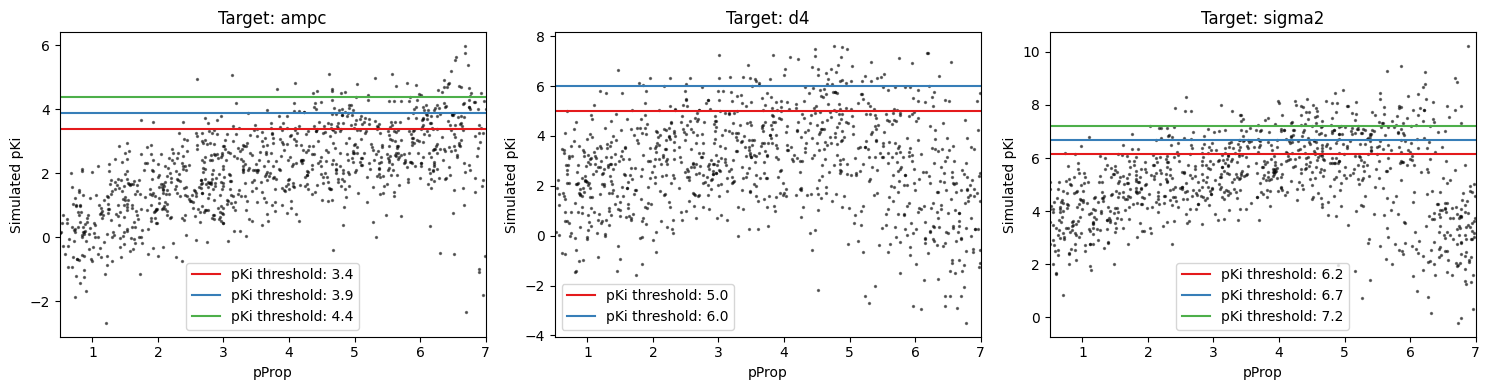

In [5]:
# Create subplots again for sampling demonstration
fig, axes = plt.subplots(1, n_targets, figsize=[n_targets*5, 4])

for i, target in enumerate(data):
    ax = axes[i]
    subset = data[target]
    hrm = HitRateModel(params[target])

    # Sample pKi values from random pProp values (uniform between pProp 0.5 and 7)
    pprop = np.random.random(1000)*6.5 + 0.5
    pKi = [hrm.sample(x) for x in pprop]

    # Plot sampled pKi values
    ax.scatter(pprop, pKi, s=2, color="k", alpha=0.5)

    # Plot horizontal lines for experimental hit thresholds
    for n, (definition, subsubset) in enumerate(subset.groupby("definition")):
        color = plt.get_cmap('Set1')(n)
        ax.plot([0.5, 7], [definition]*2, c=color, label=f"pKi threshold: {definition:.1f}")

    # Configure axes and legend
    ax.set_ylabel("Simulated pKi")
    ax.set_xlabel("pProp")
    ax.set_title("Target: " + target)
    ax.set_xlim(0.5, 7)
    ax.legend()

plt.tight_layout()
plt.show()